In [1]:
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from scvi_colab import install
install()
run_outside_colab=True
import scvi
import scipy.sparse
import decoupler as dc
import torch
import gzip
from gtfparse import read_gtf
from pybiomart import Dataset,Server
import os

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [2]:
############## Read in GENCODE for protein coding genes ################
gencode=read_gtf("../../gencode.v44.annotation.gtf")
protein_coding_genes = list(gencode.gene_name[np.where((gencode.feature=='gene')
            &(gencode.gene_type=='protein_coding')
            )[0]])

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [3]:
#nn = sc.read('../../SCORCH_HIV_data/nn.h5ad')
#nn.var_names=nn.var_names.str.upper()
#nn.var['gene_ids'] = nn.var_names
#nn.var=nn.var.reset_index(drop=True)
#nn.var_names= nn.var.gene_ids
nn = sc.read('../../HIV_data/single_cell_scorch/nn_v2_updated.h5ad')
nn

AnnData object with n_obs × n_vars = 18652 × 31463
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


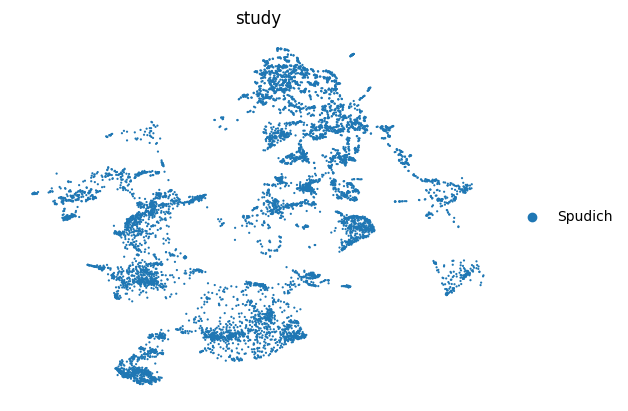

In [4]:
sc.pl.umap(
    nn[np.where((nn.obs.study=='Spudich'))[0]],
    color=["study"],
    frameon=False,
    size=10
)

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


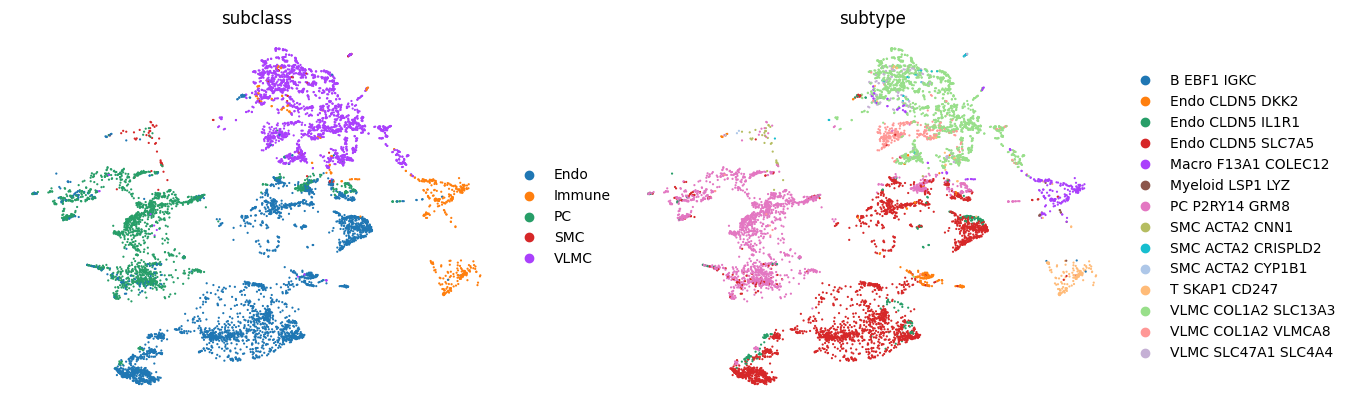

In [11]:
sc.pl.umap(
    nn[np.where((nn.obs.study=='Spudich'))[0]],
    color=["subclass","subtype"],
    frameon=False,
    size=10
)

In [5]:
nn

AnnData object with n_obs × n_vars = 18652 × 31463
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [6]:
nn.var.gene_ids.is_unique

True

In [7]:
nn = nn[:,np.where(nn.var.isin(protein_coding_genes))[0]]
nn

View of AnnData object with n_obs × n_vars = 18652 × 16953
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

## Spudich samples to work with

In [8]:
# Healthy control samples
controls = list(np.where(
    (nn.obs['sample'].str.contains('HCCCY')) |
    (nn.obs['sample'].str.contains('HCCRS')) |
    (nn.obs['sample'].str.contains('HCTGD')) |
    (nn.obs['sample'].str.contains('HCTKN')) |
    (nn.obs['sample'].str.contains('HCTLI')) |
    (nn.obs['sample'].str.contains('HCTMU')) |
    (nn.obs['sample'].str.contains('HCTMW')) |
    (nn.obs['sample'].str.contains('HCTPK')) |
    (nn.obs['sample'].str.contains('HCTTS')) |
    (nn.obs['sample'].str.contains('HCTXJ')) |
    (nn.obs['sample'].str.contains('HCcPL')) |
    (nn.obs['sample'].str.contains('HCtME')) |
    (nn.obs['sample'].str.contains('HCtNZ'))
)[0])

# HIV samples excluding OUD
hiv = list(np.where(
    (nn.obs['sample'].str.contains('10280')) |
    (nn.obs['sample'].str.contains('10288')) |
    (nn.obs['sample'].str.contains('10304')) |
    (nn.obs['sample'].str.contains('10305')) |
    (nn.obs['sample'].str.contains('1068')) |
    (nn.obs['sample'].str.contains('1129')) |
    (nn.obs['sample'].str.contains('1137')) |
    (nn.obs['sample'].str.contains('6801066772')) |
    (nn.obs['sample'].str.contains('6801187468')) |
    (nn.obs['sample'].str.contains('7100518287')) |
    (nn.obs['sample'].str.contains('7101847783')) |
    (nn.obs['sample'].str.contains('7102096765')) |
    (nn.obs['sample'].str.contains('7200776574')) 
)[0])

# HIV samples with ART
hiv_art = list(np.where(
    (nn.obs['sample'].str.contains('010280')) |
    (nn.obs['sample'].str.contains('010288')) |
    (nn.obs['sample'].str.contains('010304')) |
    (nn.obs['sample'].str.contains('010305')) |
    (nn.obs['sample'].str.contains('1129')) |
    (nn.obs['sample'].str.contains('6801066772')) |
    (nn.obs['sample'].str.contains('6801187468')) |
    (nn.obs['sample'].str.contains('7102096765')) |
    (nn.obs['sample'].str.contains('7201068268'))
)[0])

# HIV samples with no ART
hiv_no_art = list(np.where(
    (nn.obs['sample'].str.contains('1068')) |
    (nn.obs['sample'].str.contains('7100518287')) |
    (nn.obs['sample'].str.contains('7101847783')) |
    (nn.obs['sample'].str.contains('7200776574'))
)[0])

In [9]:
nn[controls].obs.subclass.value_counts()

subclass
PC        784
Endo      686
VLMC       98
Immune     85
SMC         8
Name: count, dtype: int64

In [10]:
nn[hiv].obs.subclass.value_counts()

subclass
Endo      1301
PC         466
Immune     166
VLMC       137
SMC         42
Name: count, dtype: int64

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` 

Epoch 108/300:  36%|██████████████████████▋                                        | 108/300 [09:20<16:35,  5.19s/it, v_num=1, train_loss_step=5.17e+3, train_loss_epoch=5.13e+3]
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 5178.137. Signaling Trainer to stop.


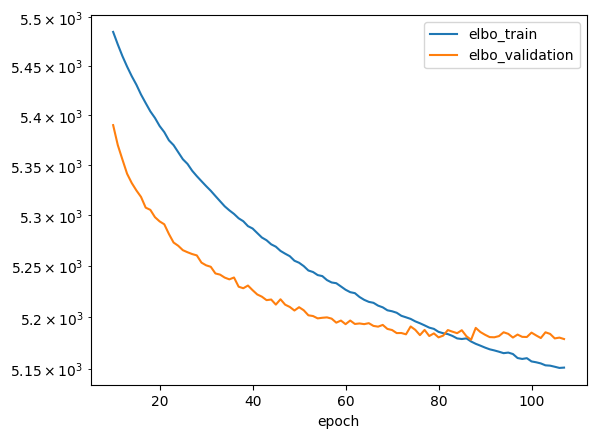

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.34s/it]
PC
Num Genes:12960
Num Cells:1250


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [04:28<00:00,  1.34s/it, v_num=1, train_loss_step=5.63e+3, train_loss_epoch=5.54e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [04:28<00:00,  1.34s/it, v_num=1, train_loss_step=5.63e+3, train_loss_epoch=5.54e+3]


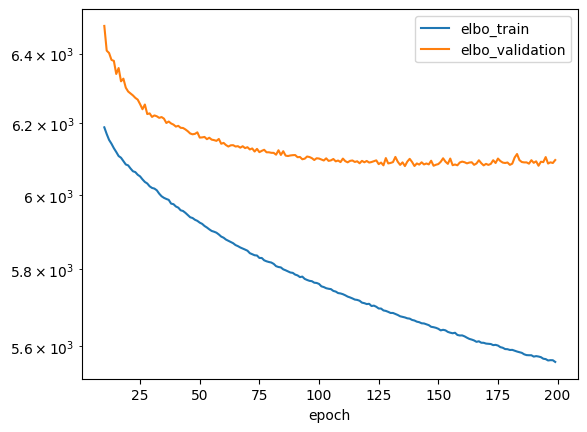

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.84s/it]
Endo
Num Genes:13186
Num Cells:1987


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 193/200:  96%|████████████████████████████████████████████████████████████▊  | 193/200 [07:11<00:15,  2.24s/it, v_num=1, train_loss_step=4.96e+3, train_loss_epoch=4.87e+3]
Monitored metric elbo_validation did not improve in the last 100 records. Best score: 5244.812. Signaling Trainer to stop.


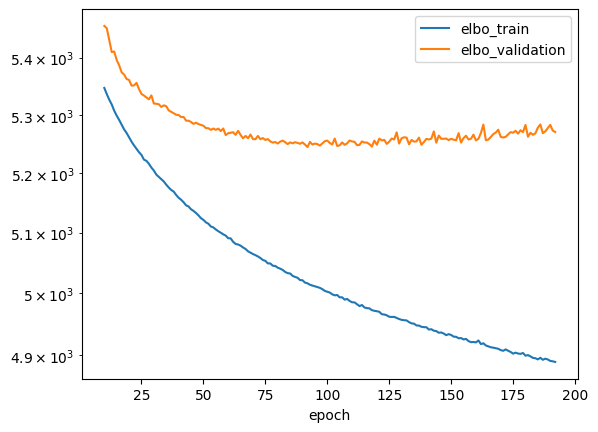

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.93s/it]
VLMC
Num Genes:6795
Num Cells:235


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.20it/s, v_num=1, train_loss_step=3.2e+3, train_loss_epoch=3.05e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.16it/s, v_num=1, train_loss_step=3.2e+3, train_loss_epoch=3.05e+3]


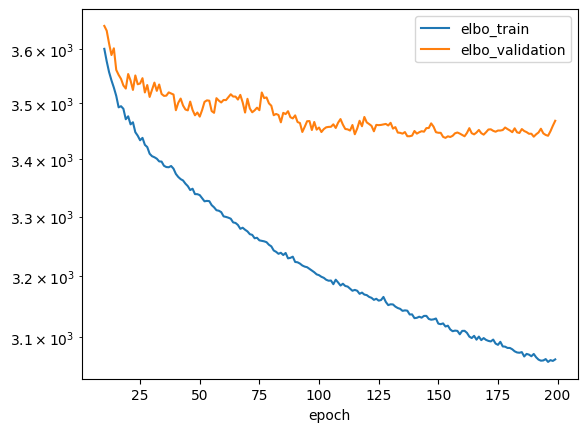

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.29s/it]
SMC
Num Genes:2231
Num Cells:50
Immune
Num Genes:6799
Num Cells:251


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.05it/s, v_num=1, train_loss_step=2.88e+3, train_loss_epoch=2.97e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.09it/s, v_num=1, train_loss_step=2.88e+3, train_loss_epoch=2.97e+3]


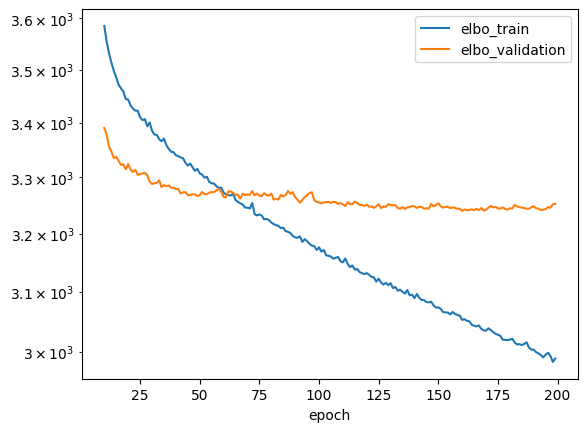

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.98s/it]


In [10]:
##################################################Parameters:##################################
adata_ref_disease = nn[hiv+controls].copy()
results_dir = '../../results/SCORCH_HIV/diff_exp/nn/hiv_pos_VS_ctrl/'
cond1 = 'hiv'
cond2 = 'ctrl'
adata_ref_disease.obs['condition'] = np.where(((adata_ref_disease.obs['sample'].str.contains('HCCCY')) |
    (adata_ref_disease.obs['sample'].str.contains('HCCRS')) | (adata_ref_disease.obs['sample'].str.contains('HCTGD')) | 
    (adata_ref_disease.obs['sample'].str.contains('HCTKN')) | (adata_ref_disease.obs['sample'].str.contains('HCTLI')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTMU')) | (adata_ref_disease.obs['sample'].str.contains('HCTMW')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTPK')) | (adata_ref_disease.obs['sample'].str.contains('HCTTS')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTXJ')) | (adata_ref_disease.obs['sample'].str.contains('HCcPL')) |
    (adata_ref_disease.obs['sample'].str.contains('HCtME')) | (adata_ref_disease.obs['sample'].str.contains('HCtNZ'))
                                         ),cond2,cond1)
#adata_ref_disease.obs['condition'] = np.where(( (adata_ref_disease.obs['sample'].str.contains('1068')) |
 #                                              (adata_ref_disease.obs['sample'].str.contains('7100518287')) | 
  #                                             (adata_ref_disease.obs['sample'].str.contains('7101847783')) |
   #                                            (adata_ref_disease.obs['sample'].str.contains('7200776574'))
    #),'hiv_no_art','hiv_art')
###############################################################################################
#sc.pp.filter_genes(adata_ref_disease, min_cells = 10)
#sc.pp.highly_variable_genes(
 #       adata_ref_disease,
  #      n_top_genes=10000,
   #     subset=True,
    #    flavor="seurat_v3"
     #   )
scvi.model.SCVI.setup_anndata(adata_ref_disease, #layer="UMIs",
                              categorical_covariate_keys=['sample','sex'],
                              continuous_covariate_keys=["age_value"]
                             )
model = scvi.model.SCVI(
    adata_ref_disease, gene_likelihood="nb"
    )  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=300,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    )
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

de_change = model.differential_expression(idx1=adata_ref_disease.obs['condition']==cond1,
                                          idx2=adata_ref_disease.obs['condition']==cond2, weights='uniform')

#de = de_change.loc[de_change['is_de_fdr_0.05']==True,:]
de_change["log10_pscore"] = (-1)*np.log10(de_change["proba_not_de"])
de_change.to_csv(results_dir+'allcells_protein_coding.tsv',sep='\t')
#de_change.to_csv(results_dir+'_allcells.tsv',sep='\t')

for cell_type in pd.unique(adata_ref_disease.obs.subclass):
    print(cell_type)
    cells = list(np.where(adata_ref_disease.obs.subclass==cell_type)[0])
    adata_cell = adata_ref_disease[cells].copy()
    sc.pp.filter_genes(adata_cell, min_cells = 10)
    #sc.pp.highly_variable_genes(
     #   adata_cell,
      #  n_top_genes=5000,
       # subset=True,
        #flavor="seurat_v3"
        #)
    print("Num Genes:"+str(len(adata_cell.var)))
    print("Num Cells:"+str(len(adata_cell.obs)))
    ################################# Skip the cell type with fewer than 10 cells in each condition#######################
    if (len(np.where(adata_cell.obs['condition']==cond1)[0])<10) | (len(np.where(adata_cell.obs['condition']==cond2)[0])<10):
        continue
    #################################
    scvi.model.SCVI.setup_anndata(adata_cell, #layer="UMIs",
                                  categorical_covariate_keys=['sample','sex'],
                                  continuous_covariate_keys=["age_value"]
                                 )
    model = scvi.model.SCVI(
        adata_cell, gene_likelihood="nb")  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
    model.train(
        check_val_every_n_epoch=1,
        max_epochs=200,
        early_stopping=True,
        early_stopping_patience=100,
        early_stopping_monitor="elbo_validation",
        batch_size=103,
        plan_kwargs={"lr": 0.001}
        )
    train_test_results = model.history["elbo_train"]
    train_test_results["elbo_validation"] = model.history["elbo_validation"]
    train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
    plt.show()
    de_change = model.differential_expression(idx1=adata_cell.obs['condition']==cond1,
                                       idx2=adata_cell.obs['condition']==cond2, weights="uniform")
    
    #de_change = de_change.loc[de['is_de_fdr_0.05']==True,:]
    de_change.loc[:,"log10_pscore"] = (-1)*np.log10(de_change["proba_not_de"])
    cell_type = cell_type.replace('/','')
    cell_type = cell_type.replace(" ","")
    de_change.to_csv(results_dir+cell_type+'_protein_coding.tsv',sep='\t')


# GSEA

In [11]:
gene_sets_to_test = ['GO_Biological_Process_2023','GO_Cellular_Component_2023','GO_Molecular_Function_2023',
                    'WikiPathway_2023_Human',
                    'MSigDB_Hallmark_2020',
                    'KEGG_2021_Human']

In [12]:
file_path_diff_exp = '../../results/SCORCH_HIV/diff_exp/nn/hiv_pos_VS_ctrl/'
file_path_gmt = '../../gene_sets/'
gsea_on = 'all_de_genes/'#'all_de_genes' or 'positive_regulated' or 'negative_regulated'
results_dir = '../../results/SCORCH_HIV/gsea/nn/'+gsea_on+'hiv_pos_VS_ctrl/'#Make sure correct DEG data frame is read as 'input_gsea'

for file in os.listdir(file_path_diff_exp):
    if 'tsv' in file:
        diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
        diff_exp.loc[:,'sign_lfc']=np.where(diff_exp['lfc_median']<0,-1,1)
        file = file.replace(" ","")
        cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
        print(cell_type)
        
        ######################## For all DEGs or separate +ve and -ve regulated genes############################
        col = np.where(diff_exp.columns=='log10_pscore')[0]
        diff_exp.loc[:,'metric_gsea'] = diff_exp['log10_pscore']*diff_exp['sign_lfc']
        input_gsea = pd.DataFrame(columns=['metric_gsea'])
        
        if gsea_on=='all_de_genes/':
            input_gsea = diff_exp.loc[:,'metric_gsea']
        #Positive DEGs:
        elif gsea_on=='upreg_genes/':
            input_gsea = diff_exp.iloc[list(np.where(diff_exp['lfc_median']>0)[0]),'metric_gsea']        
        #Negative DEGs
        elif gsea_on=='downreg_genes/':
            input_gsea = diff_exp.iloc[np.where(diff_exp.lfc_median<0)[0],'metric_gsea']

        input_gsea = input_gsea.sort_values(ascending=False)
        gsea_all_paths = pd.DataFrame()
        
        ## Exception handling for when the gmt gene set is irrelevant for the differentially expressed genes
        try:
            gsea_result = gseapy.prerank(rnk=input_gsea, gene_sets=gene_sets_to_test, organism='human')
        except LookupError:
            continue
        #filtered_sets = gsea_result.res2d.iloc[
                                            #np.where((gsea_result.res2d['NOM p-val']<=0.05)&
                                                    #(gsea_result.res2d['FDR q-val']<=0.25))[0]
                                            #,:]
        filtered_sets = gsea_result.res2d
        if len(filtered_sets)>0:
            gsea_all_paths = pd.concat([gsea_all_paths,filtered_sets]).reset_index(drop=True)
            gsea_all_paths=gsea_all_paths.drop_duplicates()
            gsea_all_paths.to_csv(results_dir+cell_type+'.tsv', sep='\t',index=False)

2024-06-06 01:15:30,753 [WARNING] Duplicated values found in preranked stats: 79.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Endo


2024-06-06 01:24:47,863 [WARNING] Duplicated values found in preranked stats: 73.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Immune


2024-06-06 01:28:19,455 [WARNING] Duplicated values found in preranked stats: 72.79% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


VLMC


2024-06-06 01:31:43,787 [WARNING] Duplicated values found in preranked stats: 81.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


allcells


2024-06-06 01:45:28,984 [WARNING] Duplicated values found in preranked stats: 80.21% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


PC


In [2]:
def get_all_DEG(file_path_diff_exp):
    all_DEG = pd.DataFrame()
    for file in os.listdir(file_path_diff_exp):
        if 'tsv' in file and 'lfc' not in file and 'allcells' not in file:
            diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
            file = file.replace(" ","")
            cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
            diff_exp.loc[:,'cell_type'] = cell_type
            diff_exp = diff_exp.reset_index().rename(columns={"index":'gene'})
        
            ######For numerical stability: replace infinite values with twice of maximum
            max_twice = diff_exp.loc[diff_exp['log10_pscore'] != np.inf, 'log10_pscore'].max()*2
            diff_exp['log10_pscore'].replace(np.inf,max_twice,inplace=True)
                
            #volcano(diff_exp,cell_type, file_path_diff_exp)
            all_DEG = pd.concat([all_DEG,diff_exp]) #Read in and saved in a previous run is used further in the volcano plot function
    all_DEG = all_DEG.reset_index(drop=True)
    return all_DEG

In [3]:
def get_selection_metric(df):
    selection_metric = df['bayes_factor'] * abs(df['lfc_median'])
    df.loc[:,'selection_metric'] = selection_metric
    return df

In [4]:
all_deg_nn = get_all_DEG('../../results/SCORCH_HIV/diff_exp/nn/hiv_pos_VS_ctrl/')
all_deg_nn = get_selection_metric(all_deg_nn)
all_deg_nn

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
0,CCK,0.9886,0.0114,4.462676,1.845756e-05,0.000249,0.0,0.25,-5.034796,-5.052711,...,0.038432,0.507289,0.030746,0.314869,0.168197,2.469464,True,1.943095,Endo,22.548610
1,ICAM5,0.9884,0.0116,4.445082,3.230064e-07,0.000010,0.0,0.25,-5.816910,-5.957384,...,0.000000,0.020408,0.000000,0.018950,0.000000,0.097189,True,1.935542,Endo,26.481058
2,RPRML,0.9880,0.0120,4.410775,1.079692e-06,0.000011,0.0,0.25,-6.796958,-7.205250,...,0.001537,0.020408,0.001537,0.020408,0.011299,0.076399,True,1.920819,Endo,31.780738
3,DPYSL4,0.9874,0.0126,4.361378,3.900151e-07,0.000007,0.0,0.25,-6.106247,-6.417537,...,0.000000,0.014577,0.000000,0.014577,0.000000,0.067150,True,1.899629,Endo,27.989301
4,IGF1,0.9866,0.0134,4.299009,3.773312e-07,0.000008,0.0,0.25,-6.520721,-6.887831,...,0.000769,0.014577,0.000769,0.014577,0.001894,0.079608,True,1.872895,Endo,29.610848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39735,AKAP9,0.5858,0.4142,0.346629,2.693558e-04,0.000249,0.0,0.25,0.091242,0.080156,...,1.339056,0.954082,0.560086,0.488520,2.671171,2.552359,False,0.382790,PC,0.027785
39736,ATRX,0.5774,0.4226,0.312109,4.603206e-04,0.000474,0.0,0.25,-0.048236,-0.038188,...,2.229614,1.850765,0.746781,0.670918,4.905909,4.724556,False,0.374071,PC,0.011919
39737,NCKAP1,0.5572,0.4428,0.229806,5.513369e-04,0.000492,0.0,0.25,0.164634,0.164628,...,2.652360,1.854592,0.757511,0.728316,5.279541,5.204469,False,0.353792,PC,0.037833
39738,N4BP2L2,0.5376,0.4624,0.150684,5.365667e-04,0.000497,0.0,0.25,0.099763,0.100001,...,2.600858,1.882653,0.759657,0.704082,5.617807,5.064706,False,0.334982,PC,0.015069


In [7]:
all_deg_nn.iloc[np.where((all_deg_nn.gene_ids=='NR3C1')#&(all_deg_nn['is_de_fdr_0.05']==True)
                        )[0],:]

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
10035,NR3C1,0.8360,0.1640,1.628762,0.000418,0.000658,0.0,0.25,-0.639151,-0.646026,...,1.822444,1.632653,0.641045,0.692420,4.457100,7.515822,False,0.785156,Endo,1.052222
19707,NR3C1,0.7914,0.2086,1.333385,0.000657,0.000581,0.0,0.25,0.123701,0.194473,...,1.421687,0.917647,0.590361,0.529412,6.854563,6.388195,False,0.680686,Immune,0.259307
25914,NR3C1,0.8174,0.1826,1.498831,0.000400,0.000629,0.0,0.25,-0.956471,-0.658492,...,0.802920,1.193877,0.401460,0.642857,3.686371,8.413031,False,0.738499,VLMC,0.986968
38961,NR3C1,0.7528,0.2472,1.113602,0.000530,0.000672,0.0,0.25,-0.345527,-0.371474,...,2.592275,2.827806,0.744635,0.750000,5.544480,7.075984,False,0.606952,PC,0.413674
